In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install bayesian-optimization==0.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for bayesian-optimization: filename=bayesian_optimization-0.6.0-py3-none-any.whl size=10824 sha256=0bce16600987bebd0f07a9b3006378e6ec03438e934628d6808270c40127846a
  Stored in directory: /root/.cache/pip/wheels/72/88/a6/b649cdcbd90b7674f43d2e14ed9ce0b4297cf7da766370f821
Successfully built bayesian-optimization
  Attempting uninstall: bayesian-optimization
    Found existing installation: bayesian-optimization 1.4.2
    Uninstalling bayesian-optimization-1.4.2:
      Successfully uninstalled bayesian-optimization-1.4.2


In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
from bayes_opt import BayesianOptimization
sns.set()

In [ ]:
import pkg_resources
import types


def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split('.')[0]
        elif isinstance(val, type):
            name = val.__module__.split('.')[0]
        poorly_named_packages = {'PIL': 'Pillow', 'sklearn': 'scikit-learn'}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name


imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != 'pip':
        requirements.append((m.project_name, m.version))

for r in requirements:
    print('{}=={}'.format(*r))

seaborn==0.11.2
pandas==1.3.5
numpy==1.21.6
matplotlib==3.2.2
google==2.0.3


In [ ]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[0 : t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Đồ án biểu diễn (Dự báo giá chứng khoán)/dataset/VNM.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-12-01,20.879999,20.980000,20.750000,20.799999,20.696852,195600
1,2021-12-02,20.799999,20.850000,20.680000,20.719999,20.617249,296800
2,2021-12-03,20.500000,20.549999,20.280001,20.370001,20.268986,251000
3,2021-12-06,20.000000,20.049999,19.870001,20.010000,19.910770,502800
4,2021-12-07,20.379999,20.559999,20.320000,20.510000,20.408291,339700


In [ ]:
close = df.Close.values.tolist()
window_size = 30
skip = 5
l = len(close) - 1

In [ ]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [ ]:
class Agent:
    def __init__(
        self,
        population_size,
        sigma,
        learning_rate,
        model,
        money,
        max_buy,
        max_sell,
        skip,
        window_size,
    ):
        self.window_size = window_size
        self.skip = skip
        self.POPULATION_SIZE = population_size
        self.SIGMA = sigma
        self.LEARNING_RATE = learning_rate
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = get_state(close, 0, self.window_size + 1)
        inventory = []
        quantity = 0
        for t in range(0, l, self.skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell

            state = next_state
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = get_state(close, 0, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(0, l, self.skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (t, sell_units, total_sell, invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        print(
            '\ntotal gained %f, total investment %f %%'
            % (initial_money - starting_money, invest)
        )
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.show()

In [ ]:
def best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    model = Model(window_size, size_network, 3)
    agent = Agent(
        population_size,
        sigma,
        learning_rate,
        model,
        10000,
        5,
        5,
        skip,
        window_size,
    )
    try:
        agent.fit(100, 1000)
        return agent.es.reward_function(agent.es.weights)
    except:
        return 0

In [ ]:
def find_best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    global accbest
    param = {
        'window_size': int(np.around(window_size)),
        'skip': int(np.around(skip)),
        'population_size': int(np.around(population_size)),
        'sigma': max(min(sigma, 1), 0.0001),
        'learning_rate': max(min(learning_rate, 0.5), 0.000001),
        'size_network': int(np.around(size_network)),
    }
    print('\nSearch parameters %s' % (param))
    investment = best_agent(**param)
    print('stop after 100 iteration with investment %f' % (investment))
    if investment > accbest:
        costbest = investment
    return investment

In [ ]:
accbest = 0.0
NN_BAYESIAN = BayesianOptimization(
    find_best_agent,
    {
        'window_size': (2, 50),
        'skip': (1, 15),
        'population_size': (1, 50),
        'sigma': (0.01, 0.99),
        'learning_rate': (0.000001, 0.49),
        'size_network': (10, 1000),
    },
)
NN_BAYESIAN.maximize(init_points = 30, n_iter = 50, acq = 'ei', xi = 0.0)

Initialization
----------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   learning_rate |   population_size |     sigma |   size_network |      skip |   window_size | 

Search parameters {'window_size': 19, 'skip': 10, 'population_size': 11, 'sigma': 0.8900421480741226, 'learning_rate': 0.12059681249141262, 'size_network': 929}


<ipython-input-7-4efaf2b7209b>:39: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


stop after 100 iteration with investment 0.000000
    1 | 00m01s |    0.00000 |          0.1206 |           11.3242 |    0.8900 |       929.0232 |    9.5340 |       18.5421 | 

Search parameters {'window_size': 13, 'skip': 6, 'population_size': 37, 'sigma': 0.15038548624182901, 'learning_rate': 0.35864987953585103, 'size_network': 938}
stop after 100 iteration with investment 0.000000
    2 | 00m00s |    0.00000 |          0.3586 |           37.2227 |    0.1504 |       938.0085 |    5.8775 |       12.6050 | 

Search parameters {'window_size': 30, 'skip': 13, 'population_size': 44, 'sigma': 0.7082180541258644, 'learning_rate': 0.012093246929403592, 'size_network': 279}
time taken to train: 4.53752875328064 seconds
stop after 100 iteration with investment 0.000000
    3 | 00m04s |    0.00000 |          0.0121 |           43.6351 |    0.7082 |       278.5274 |   12.6679 |       29.5976 | 

Search parameters {'window_size': 49, 'skip': 4, 'population_size': 41, 'sigma': 0.6294685850392057,

<ipython-input-7-4efaf2b7209b>:39: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)



Search parameters {'window_size': 2, 'skip': 1, 'population_size': 50, 'sigma': 0.01, 'learning_rate': 0.49, 'size_network': 10}


<ipython-input-7-4efaf2b7209b>:39: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


stop after 100 iteration with investment 0.000000
   33 | 00m15s |    0.00000 |          0.4900 |           50.0000 |    0.0100 |        10.0000 |    1.0000 |        2.0000 | 

Search parameters {'window_size': 2, 'skip': 15, 'population_size': 50, 'sigma': 0.99, 'learning_rate': 1e-06, 'size_network': 1000}
time taken to train: 3.4560351371765137 seconds
stop after 100 iteration with investment 0.000000
   34 | 00m18s |    0.00000 |          0.0000 |           50.0000 |    0.9900 |      1000.0000 |   15.0000 |        2.0000 | 

Search parameters {'window_size': 50, 'skip': 1, 'population_size': 50, 'sigma': 0.99, 'learning_rate': 1e-06, 'size_network': 1000}
time taken to train: 101.79722213745117 seconds
stop after 100 iteration with investment 0.040100
   35 | 01m57s |    0.04010 |          0.0000 |           50.0000 |    0.9900 |      1000.0000 |    1.0000 |       50.0000 | 

Search parameters {'window_size': 50, 'skip': 15, 'population_size': 1, 'sigma': 0.99, 'learning_rate': 0.4

<ipython-input-7-4efaf2b7209b>:39: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)



Search parameters {'window_size': 50, 'skip': 1, 'population_size': 50, 'sigma': 0.99, 'learning_rate': 0.49, 'size_network': 66}
time taken to train: 40.53616738319397 seconds
stop after 100 iteration with investment 0.046000
   37 | 00m59s |    0.04600 |          0.4900 |           50.0000 |    0.9900 |        65.7843 |    1.0000 |       50.0000 | 

Search parameters {'window_size': 50, 'skip': 15, 'population_size': 50, 'sigma': 0.99, 'learning_rate': 0.49, 'size_network': 473}
time taken to train: 14.735780239105225 seconds
stop after 100 iteration with investment 0.079500
   38 | 00m33s |    0.07950 |          0.4900 |           50.0000 |    0.9900 |       472.8274 |   15.0000 |       50.0000 | 

Search parameters {'window_size': 2, 'skip': 1, 'population_size': 1, 'sigma': 0.99, 'learning_rate': 0.49, 'size_network': 793}
stop after 100 iteration with investment 0.000000
   39 | 00m19s |    0.00000 |          0.4900 |            1.0000 |    0.9900 |       793.0297 |    1.0000 | 

<ipython-input-7-4efaf2b7209b>:39: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)



Search parameters {'window_size': 50, 'skip': 1, 'population_size': 50, 'sigma': 0.01, 'learning_rate': 0.49, 'size_network': 168}


<ipython-input-7-4efaf2b7209b>:39: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


stop after 100 iteration with investment 0.000000
   40 | 00m18s |    0.00000 |          0.4900 |           50.0000 |    0.0100 |       168.3820 |    1.0000 |       50.0000 | 

Search parameters {'window_size': 50, 'skip': 15, 'population_size': 50, 'sigma': 0.01, 'learning_rate': 1e-06, 'size_network': 10}
time taken to train: 2.5202479362487793 seconds
stop after 100 iteration with investment -1.320100
   41 | 00m18s |   -1.32010 |          0.0000 |           50.0000 |    0.0100 |        10.0000 |   15.0000 |       50.0000 | 

Search parameters {'window_size': 50, 'skip': 1, 'population_size': 1, 'sigma': 0.99, 'learning_rate': 0.49, 'size_network': 10}
stop after 100 iteration with investment 0.000000
   42 | 00m17s |    0.00000 |          0.4900 |            1.0000 |    0.9900 |        10.0000 |    1.0000 |       50.0000 | 


<ipython-input-7-4efaf2b7209b>:39: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)



Search parameters {'window_size': 50, 'skip': 1, 'population_size': 1, 'sigma': 0.01, 'learning_rate': 1e-06, 'size_network': 514}
stop after 100 iteration with investment 0.000000
   43 | 00m12s |    0.00000 |          0.0000 |            1.0000 |    0.0100 |       513.7522 |    1.0000 |       50.0000 | 


<ipython-input-7-4efaf2b7209b>:39: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)
/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(



Search parameters {'window_size': 29, 'skip': 5, 'population_size': 14, 'sigma': 0.12096168448318984, 'learning_rate': 0.17724126559382555, 'size_network': 298}


<ipython-input-7-4efaf2b7209b>:39: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


stop after 100 iteration with investment 0.000000
   44 | 00m02s |    0.00000 |          0.1772 |           14.0071 |    0.1210 |       298.3294 |    5.0887 |       28.7902 | 

Search parameters {'window_size': 2, 'skip': 1, 'population_size': 50, 'sigma': 0.99, 'learning_rate': 0.49, 'size_network': 123}
time taken to train: 17.821676015853882 seconds
stop after 100 iteration with investment 0.034500
   45 | 00m30s |    0.03450 |          0.4900 |           50.0000 |    0.9900 |       123.0324 |    1.0000 |        2.0000 | 

Search parameters {'window_size': 50, 'skip': 1, 'population_size': 1, 'sigma': 0.01, 'learning_rate': 0.49, 'size_network': 740}
stop after 100 iteration with investment 0.000000
   46 | 00m14s |    0.00000 |          0.4900 |            1.0000 |    0.0100 |       739.9807 |    1.0000 |       50.0000 | 


<ipython-input-7-4efaf2b7209b>:39: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)



Search parameters {'window_size': 2, 'skip': 1, 'population_size': 1, 'sigma': 0.01, 'learning_rate': 1e-06, 'size_network': 464}
stop after 100 iteration with investment 0.000000
   47 | 00m15s |    0.00000 |          0.0000 |            1.0000 |    0.0100 |       463.8554 |    1.0000 |        2.0000 | 


<ipython-input-7-4efaf2b7209b>:39: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)



Search parameters {'window_size': 50, 'skip': 1, 'population_size': 1, 'sigma': 0.99, 'learning_rate': 0.49, 'size_network': 107}
stop after 100 iteration with investment 0.000000
   48 | 00m15s |    0.00000 |          0.4900 |            1.0000 |    0.9900 |       106.5841 |    1.0000 |       50.0000 | 


<ipython-input-7-4efaf2b7209b>:39: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)



Search parameters {'window_size': 2, 'skip': 1, 'population_size': 50, 'sigma': 0.01, 'learning_rate': 0.49, 'size_network': 637}


<ipython-input-7-4efaf2b7209b>:39: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


stop after 100 iteration with investment 0.000000
   49 | 00m16s |    0.00000 |          0.4900 |           50.0000 |    0.0100 |       637.2736 |    1.0000 |        2.0000 | 

Search parameters {'window_size': 2, 'skip': 15, 'population_size': 50, 'sigma': 0.99, 'learning_rate': 0.49, 'size_network': 841}


<ipython-input-7-4efaf2b7209b>:39: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


stop after 100 iteration with investment 0.000000
   50 | 00m16s |    0.00000 |          0.4900 |           50.0000 |    0.9900 |       841.3328 |   15.0000 |        2.0000 | 

Search parameters {'window_size': 2, 'skip': 1, 'population_size': 50, 'sigma': 0.01, 'learning_rate': 0.49, 'size_network': 751}


<ipython-input-7-4efaf2b7209b>:39: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


stop after 100 iteration with investment 0.000000
   51 | 00m16s |    0.00000 |          0.4900 |           50.0000 |    0.0100 |       750.5120 |    1.0000 |        2.0000 | 

Search parameters {'window_size': 50, 'skip': 15, 'population_size': 1, 'sigma': 0.01, 'learning_rate': 0.49, 'size_network': 653}
stop after 100 iteration with investment 0.000000
   52 | 00m16s |    0.00000 |          0.4900 |            1.0000 |    0.0100 |       653.4538 |   15.0000 |       50.0000 | 


<ipython-input-7-4efaf2b7209b>:39: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)



Search parameters {'window_size': 50, 'skip': 15, 'population_size': 1, 'sigma': 0.01, 'learning_rate': 0.49, 'size_network': 1000}
stop after 100 iteration with investment 0.000000
   53 | 00m19s |    0.00000 |          0.4900 |            1.0000 |    0.0100 |      1000.0000 |   15.0000 |       50.0000 | 


<ipython-input-7-4efaf2b7209b>:39: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)



Search parameters {'window_size': 50, 'skip': 1, 'population_size': 50, 'sigma': 0.99, 'learning_rate': 1e-06, 'size_network': 552}
time taken to train: 83.68684411048889 seconds
stop after 100 iteration with investment -58.922300
   54 | 01m42s |  -58.92230 |          0.0000 |           50.0000 |    0.9900 |       551.7027 |    1.0000 |       50.0000 | 

Search parameters {'window_size': 41, 'skip': 15, 'population_size': 2, 'sigma': 0.01, 'learning_rate': 0.49, 'size_network': 610}
stop after 100 iteration with investment 0.000000
   55 | 00m11s |    0.00000 |          0.4900 |            1.9336 |    0.0100 |       610.2895 |   15.0000 |       41.0601 | 


<ipython-input-7-4efaf2b7209b>:39: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)



Search parameters {'window_size': 40, 'skip': 3, 'population_size': 49, 'sigma': 0.9486365739458227, 'learning_rate': 0.10181547587152187, 'size_network': 965}
time taken to train: 43.41016411781311 seconds
stop after 100 iteration with investment 0.000000
   56 | 00m54s |    0.00000 |          0.1018 |           49.4946 |    0.9486 |       964.9853 |    2.6558 |       39.6048 | 

Search parameters {'window_size': 36, 'skip': 7, 'population_size': 47, 'sigma': 0.7600131306925021, 'learning_rate': 0.41719958756741765, 'size_network': 309}


<ipython-input-7-4efaf2b7209b>:39: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


stop after 100 iteration with investment 0.000000
   57 | 00m03s |    0.00000 |          0.4172 |           46.9950 |    0.7600 |       309.2648 |    6.6179 |       36.0051 | 

Search parameters {'window_size': 18, 'skip': 15, 'population_size': 50, 'sigma': 0.99, 'learning_rate': 1e-06, 'size_network': 308}
time taken to train: 3.643052577972412 seconds
stop after 100 iteration with investment -1.304500
   58 | 00m14s |   -1.30450 |          0.0000 |           50.0000 |    0.9900 |       308.2702 |   15.0000 |       18.1263 | 

Search parameters {'window_size': 46, 'skip': 13, 'population_size': 50, 'sigma': 0.99, 'learning_rate': 1e-06, 'size_network': 325}
time taken to train: 11.53079080581665 seconds
stop after 100 iteration with investment -0.036200
   59 | 00m25s |   -0.03620 |          0.0000 |           50.0000 |    0.9900 |       324.6325 |   12.9890 |       46.3657 | 

Search parameters {'window_size': 2, 'skip': 15, 'population_size': 6, 'sigma': 0.01, 'learning_rate': 0.49

<ipython-input-7-4efaf2b7209b>:39: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)



Search parameters {'window_size': 23, 'skip': 1, 'population_size': 49, 'sigma': 0.99, 'learning_rate': 0.49, 'size_network': 357}
time taken to train: 29.602038621902466 seconds
stop after 100 iteration with investment 0.121000
   61 | 00m42s |    0.12100 |          0.4900 |           48.7367 |    0.9900 |       356.6649 |    1.0000 |       23.1669 | 

Search parameters {'window_size': 22, 'skip': 15, 'population_size': 25, 'sigma': 0.01, 'learning_rate': 0.49, 'size_network': 980}
stop after 100 iteration with investment 0.000000
   62 | 00m13s |    0.00000 |          0.4900 |           25.0621 |    0.0100 |       979.6798 |   15.0000 |       21.6175 | 


<ipython-input-7-4efaf2b7209b>:39: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)



Search parameters {'window_size': 24, 'skip': 1, 'population_size': 29, 'sigma': 0.6787663054793741, 'learning_rate': 0.19393800549194254, 'size_network': 250}


<ipython-input-7-4efaf2b7209b>:39: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


stop after 100 iteration with investment 0.000000
   63 | 00m20s |    0.00000 |          0.1939 |           29.2259 |    0.6788 |       250.2362 |    1.0000 |       23.6176 | 

Search parameters {'window_size': 2, 'skip': 4, 'population_size': 32, 'sigma': 0.7075569811529545, 'learning_rate': 0.49, 'size_network': 493}
time taken to train: 5.02668309211731 seconds
stop after 100 iteration with investment 0.052500
   64 | 00m17s |    0.05250 |          0.4900 |           31.9234 |    0.7076 |       492.8048 |    4.3491 |        2.0000 | 

Search parameters {'window_size': 7, 'skip': 1, 'population_size': 25, 'sigma': 0.99, 'learning_rate': 0.49, 'size_network': 353}
time taken to train: 11.150128364562988 seconds
stop after 100 iteration with investment 0.127000
   65 | 00m22s |    0.12700 |          0.4900 |           24.5876 |    0.9900 |       352.9662 |    1.0000 |        7.1873 | 

Search parameters {'window_size': 29, 'skip': 15, 'population_size': 24, 'sigma': 0.99, 'learning_rat

<ipython-input-7-4efaf2b7209b>:39: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


stop after 100 iteration with investment 0.000000
   66 | 00m13s |    0.00000 |          0.4900 |           23.5033 |    0.9900 |       367.4958 |   15.0000 |       29.1856 | 

Search parameters {'window_size': 49, 'skip': 3, 'population_size': 1, 'sigma': 0.01, 'learning_rate': 0.06599017618251948, 'size_network': 483}
stop after 100 iteration with investment 0.000000
   67 | 00m11s |    0.00000 |          0.0660 |            1.0000 |    0.0100 |       482.7163 |    2.6324 |       49.3496 | 


<ipython-input-7-4efaf2b7209b>:39: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)



Search parameters {'window_size': 2, 'skip': 4, 'population_size': 3, 'sigma': 0.01, 'learning_rate': 0.49, 'size_network': 327}
stop after 100 iteration with investment 0.000000
   68 | 00m11s |    0.00000 |          0.4900 |            2.5639 |    0.0100 |       326.9331 |    4.0226 |        2.0000 | 


<ipython-input-7-4efaf2b7209b>:39: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)



Search parameters {'window_size': 30, 'skip': 15, 'population_size': 50, 'sigma': 0.01, 'learning_rate': 1e-06, 'size_network': 96}
time taken to train: 2.8418049812316895 seconds
stop after 100 iteration with investment -0.826000
   69 | 00m15s |   -0.82600 |          0.0000 |           50.0000 |    0.0100 |        95.8965 |   15.0000 |       29.7248 | 

Search parameters {'window_size': 50, 'skip': 15, 'population_size': 21, 'sigma': 0.99, 'learning_rate': 0.49, 'size_network': 140}
time taken to train: 1.8921165466308594 seconds
stop after 100 iteration with investment 0.079500
   70 | 00m13s |    0.07950 |          0.4900 |           20.7577 |    0.9900 |       139.7956 |   15.0000 |       50.0000 | 

Search parameters {'window_size': 50, 'skip': 1, 'population_size': 50, 'sigma': 0.99, 'learning_rate': 0.0015217459653268561, 'size_network': 443}
time taken to train: 80.6003086566925 seconds
stop after 100 iteration with investment -24.259700
   71 | 01m32s |  -24.25970 |         

<ipython-input-7-4efaf2b7209b>:39: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


stop after 100 iteration with investment 0.000000
   72 | 00m16s |    0.00000 |          0.4900 |           50.0000 |    0.9900 |       486.7472 |   15.0000 |       49.9864 | 

Search parameters {'window_size': 26, 'skip': 4, 'population_size': 43, 'sigma': 0.01, 'learning_rate': 0.1145809358970981, 'size_network': 402}


<ipython-input-7-4efaf2b7209b>:39: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


stop after 100 iteration with investment 0.000000
   73 | 00m11s |    0.00000 |          0.1146 |           43.3425 |    0.0100 |       401.7052 |    3.9480 |       25.6800 | 

Search parameters {'window_size': 7, 'skip': 1, 'population_size': 43, 'sigma': 0.030958937760635984, 'learning_rate': 0.49, 'size_network': 349}


<ipython-input-7-4efaf2b7209b>:39: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


stop after 100 iteration with investment 0.000000
   74 | 00m11s |    0.00000 |          0.4900 |           43.0786 |    0.0310 |       348.7148 |    1.0000 |        6.6822 | 

Search parameters {'window_size': 50, 'skip': 15, 'population_size': 31, 'sigma': 0.01, 'learning_rate': 0.49, 'size_network': 990}


<ipython-input-7-4efaf2b7209b>:39: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


stop after 100 iteration with investment 0.000000
   75 | 00m10s |    0.00000 |          0.4900 |           30.9466 |    0.0100 |       990.1423 |   15.0000 |       50.0000 | 

Search parameters {'window_size': 26, 'skip': 1, 'population_size': 50, 'sigma': 0.21019531344813092, 'learning_rate': 0.49, 'size_network': 991}
time taken to train: 70.88131213188171 seconds
stop after 100 iteration with investment 0.233700
   76 | 01m22s |    0.23370 |          0.4900 |           50.0000 |    0.2102 |       990.8173 |    1.0000 |       25.8778 | 

Search parameters {'window_size': 28, 'skip': 1, 'population_size': 38, 'sigma': 0.99, 'learning_rate': 1e-06, 'size_network': 1000}
time taken to train: 54.61490249633789 seconds
stop after 100 iteration with investment -27.752300
   77 | 01m05s |  -27.75230 |          0.0000 |           37.6239 |    0.9900 |      1000.0000 |    1.0000 |       28.4237 | 

Search parameters {'window_size': 24, 'skip': 1, 'population_size': 50, 'sigma': 0.01, 'learni

<ipython-input-7-4efaf2b7209b>:39: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


stop after 100 iteration with investment 0.000000
   78 | 00m04s |    0.00000 |          0.4900 |           50.0000 |    0.0100 |       985.3509 |    1.0790 |       24.4820 | 

Search parameters {'window_size': 42, 'skip': 13, 'population_size': 44, 'sigma': 0.27148388569144144, 'learning_rate': 0.49, 'size_network': 985}


<ipython-input-7-4efaf2b7209b>:39: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


stop after 100 iteration with investment 0.000000
   79 | 00m04s |    0.00000 |          0.4900 |           44.3143 |    0.2715 |       985.2374 |   12.6366 |       42.2160 | 

Search parameters {'window_size': 34, 'skip': 10, 'population_size': 50, 'sigma': 0.99, 'learning_rate': 1e-06, 'size_network': 317}
time taken to train: 10.794307470321655 seconds
stop after 100 iteration with investment -0.262100
   80 | 00m14s |   -0.26210 |          0.0000 |           50.0000 |    0.9900 |       316.8322 |    9.9594 |       34.2352 | 


In [ ]:
print('Best AGENT accuracy value: %f' % NN_BAYESIAN.res['max']['max_val'])
print('Best AGENT parameters: ', NN_BAYESIAN.res['max']['max_params'])

Best AGENT accuracy value: 0.233700
Best AGENT parameters:  {'window_size': 25.877802188297306, 'skip': 1.0, 'population_size': 50.0, 'sigma': 0.21019531344813092, 'learning_rate': 0.49, 'size_network': 990.8173448028592}


#### Chọn đại parameters

In [ ]:
best_agent(
    window_size = 30,
    skip = 1,
    population_size = 15,
    sigma = 0.1,
    learning_rate = 0.03,
    size_network = 500
)

time taken to train: 19.03764510154724 seconds


0.08940020999996705

#### bayesian parameters

In [ ]:
best_agent(
    window_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['window_size'])),
    skip = int(np.around(NN_BAYESIAN.res['max']['max_params']['skip'])),
    population_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['population_size'])),
    sigma = NN_BAYESIAN.res['max']['max_params']['sigma'],
    learning_rate = NN_BAYESIAN.res['max']['max_params']['learning_rate'],
    size_network = int(np.around(NN_BAYESIAN.res['max']['max_params']['size_network']))
)

time taken to train: 72.42936420440674 seconds


0.3825

#### Chọn đại parameters

iter 100. reward: 0.266200
iter 200. reward: 0.387300
iter 300. reward: 0.561800
iter 400. reward: 0.583000
iter 500. reward: 0.635800
time taken to train: 96.82272934913635 seconds
day 0: buy 1 units at price 20.799999, total balance 9979.200001
day 1: buy 1 units at price 20.719999, total balance 9958.480002
day 2: buy 1 units at price 20.370001, total balance 9938.110001
day 3: buy 1 units at price 20.010000, total balance 9918.100001
day 4: buy 5 units at price 102.550000, total balance 9815.550001
day 5: buy 5 units at price 103.500005, total balance 9712.049996
day 7, sell 5 units at price 103.400000, investment 397.115409 %, total balance 9815.449996,
day 9: buy 5 units at price 103.450005, total balance 9711.999991
day 10: buy 5 units at price 103.700000, total balance 9608.299991
day 11: buy 1 units at price 20.709999, total balance 9587.589992
day 12: buy 1 units at price 20.770000, total balance 9566.819992
day 13: buy 1 units at price 20.600000, total balance 9546.219992
da

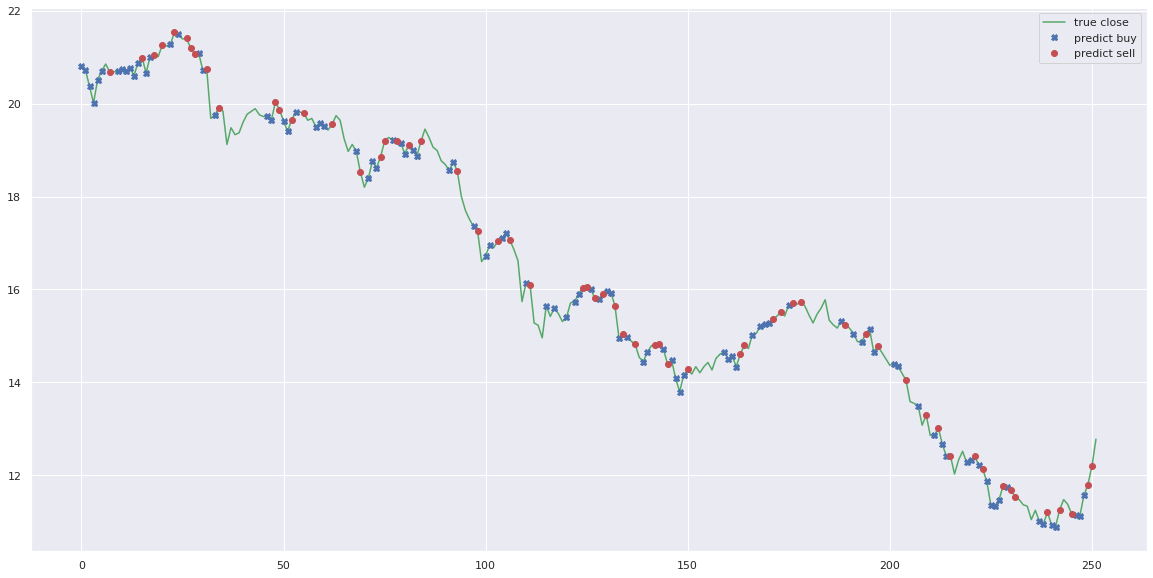

In [ ]:
model = Model(input_size = 30,
              layer_size = 500,
              output_size = 3)
agent = Agent(population_size = 15,
              sigma = 0.1,
              learning_rate = 0.03,
              model = model,
              money = 10000,
              max_buy = 5,
              max_sell = 5,
              skip = 1,
              window_size = 30)
agent.fit(500, 100)
agent.buy()

#### bayesian parameters

iter 100. reward: 0.509500
iter 200. reward: 0.561200
iter 300. reward: 0.637700
iter 400. reward: 0.759200
iter 500. reward: 0.664400
time taken to train: 357.3771057128906 seconds
day 2: buy 5 units at price 101.850005, total balance 9898.149995
day 3: buy 5 units at price 100.050000, total balance 9798.099995
day 4, sell 5 units at price 102.550000, investment 0.687280 %, total balance 9900.649995,
day 5, sell 5 units at price 103.500005, investment 3.448281 %, total balance 10004.150000,
day 7: buy 5 units at price 103.400000, total balance 9900.750000
day 8: buy 5 units at price 103.400000, total balance 9797.350000
day 9: buy 5 units at price 103.450005, total balance 9693.899995
day 11, sell 5 units at price 103.549995, investment 0.145063 %, total balance 9797.449990,
day 12, sell 5 units at price 103.850000, investment 0.435203 %, total balance 9901.299990,
day 13: buy 5 units at price 103.000000, total balance 9798.299990
day 14, sell 5 units at price 104.399995, investment 0

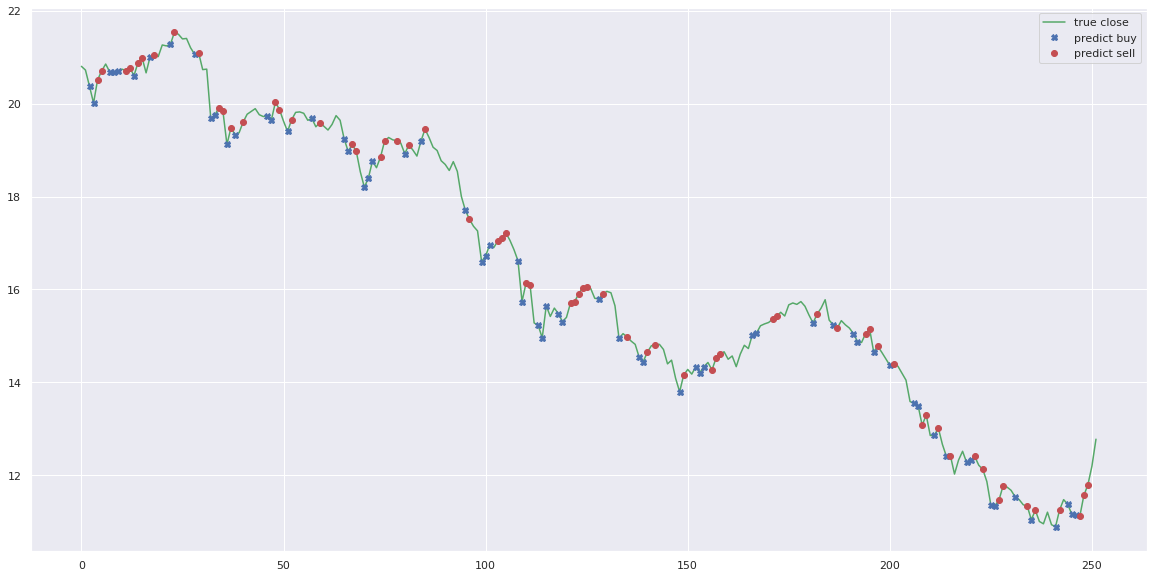

In [ ]:
model = Model(input_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['window_size'])),
              layer_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['size_network'])),
              output_size = 3)
agent = Agent(population_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['population_size'])),
              sigma = NN_BAYESIAN.res['max']['max_params']['sigma'],
              learning_rate = NN_BAYESIAN.res['max']['max_params']['learning_rate'],
              model = model,
              money = 10000,
              max_buy = 5,
              max_sell = 5,
              skip = int(np.around(NN_BAYESIAN.res['max']['max_params']['skip'])),
              window_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['window_size'])))
agent.fit(500, 100)
agent.buy()